In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import numpy as np
import matplotlib.pylab as plt
from FH_Functions import opt_fracs
from GP_Functions import EXP_predict, search_data

In [2]:
def pol2cart(rho, phi):
    """Convert polar to cartesian coordinates"""
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return np.array([x, y])

def circle_search_sim(N_sims, N_strips, N_samps, lam, mu, l, epsilon, seed = 0):
    """Compare the cost of QS with FH Search over boundaries drawn from GP"""
    FH_policy = opt_fracs(N_samps,lam)
    QS_policy = (1/2 - lam/4)*np.ones(N_samps)
    
    N     = 100
    theta = np.linspace(0,2*np.pi,N)
    SIG   = EXP_cov(theta,theta,l)
    
    FH_cost = 0
    QS_cost = 0
    
    FH_err = 0
    QS_err = 0
    
    FH_dist = 0
    QS_dist = 0
    
    np.random.seed(seed)
    
    for episode in range(N_sims):
        yy    = np.random.multivariate_normal(mean=mu*np.ones(N), cov=SIG)

        sampLocs = []
        samps    = np.linspace(0,2*np.pi,N_strips+1)
        for samp in samps:
            sampLocs.append(np.argmin(np.abs(samp-theta)))
        sampLocs = np.asarray(sampLocs)
        sampVals = yy[sampLocs]
        
        FH_tht_ests = []
        QS_tht_ests = []
        
        for ii, tht in enumerate(sampVals[:-1]):
            
            # Perform FH Search
            if not ii:
                lb = 0
                ub = 2*mu
                x_init = 0
                add_dist = 0
            else:
                thtEst = fh.est
                add_dist = np.linalg.norm(pol2cart(thtEst, samps[ii]) - pol2cart(thtEst, samps[ii-1]))
                if thtEst < tht:
                    lb = thtEst
                    ub = 2*mu
                else:
                    ub = thtEst        
                    lb = 0
                x_init = thtEst
            fh = search_data()
            fh.search(FH_policy, tht, ub, lb, x_init)
            FH_cost += fh.err + lam*(fh.tot_dist + add_dist)
            FH_dist += fh.tot_dist + add_dist
            
            FH_thtEst = fh.est
            FH_tht_ests.append(FH_thtEst)
            
            # Perform QS Search
            if not ii:
                lb = 0
                ub = 2*mu
                x_init = 0
                add_dist = 0
            else:
                thtEst = qs.est
                add_dist = np.linalg.norm(pol2cart(thtEst, samps[ii]) - pol2cart(thtEst, samps[ii-1]))
                if thtEst < tht:
                    lb = thtEst
                    ub = 2*mu
                else:
                    ub = thtEst        
                    lb = 0
                x_init = thtEst
            qs = search_data()
            qs.search(QS_policy, tht, ub, lb, x_init)
            QS_cost += qs.err + lam*(qs.tot_dist + add_dist)
            QS_dist += qs.tot_dist + add_dist
            

            QS_thtEst = qs.est
            QS_tht_ests.append(QS_thtEst)

        FH_tht_ests.append(FH_tht_ests[0])
        FH_tht_ests = np.array(FH_tht_ests)
        predictions = [EXP_predict(i, theta[sampLocs], FH_tht_ests, mu, mu, l, epsilon) for i in theta]
        y_pred, sigmas = np.transpose(predictions)
        FH_err += np.sum(np.abs(yy - y_pred))/N

        
        QS_tht_ests.append(QS_tht_ests[0])
        QS_tht_ests = np.array(QS_tht_ests)
        predictions = [EXP_predict(i, theta[sampLocs], QS_tht_ests, mu, mu, l, epsilon) for i in theta]
        y_pred, sigmas = np.transpose(predictions)
        QS_err += np.sum(np.abs(yy - y_pred))/N 
        
        
    FH_cost /= N_sims
    FH_dist /= N_sims
    FH_err  /= N_sims

    QS_cost /= N_sims
    QS_dist /= N_sims
    QS_err  /= N_sims
    
    return FH_cost, QS_cost, FH_err, QS_err, FH_dist, QS_dist

In [4]:
lam = 0.4
mu  = 3       # mean distance from origin
l   = 0.4     # length scale for covariance kernel
eps = 0.1     # noise on GP

In [12]:
Ns = np.arange(3, 21, 1)
N_sims = 100

fh_costs = []
qs_costs = []
cost_improves = []

fh_errs = []
qs_errs = []
err_improves = []

fh_dists = []
qs_dists = []
dist_improves = []

for N_strips in Ns:
    N_samps = int((100 - N_strips)/N_strips)
    fh_cost, qs_cost, fh_err, qs_err, fh_dist, qs_dist = circle_search_sim(N_sims, N_strips, N_samps, lam, mu, l, eps)

    cost_improve = 100*(qs_cost - fh_cost)/qs_cost    
    err_improve  = 100*(qs_err - fh_err)/qs_err
    dist_improve = 100*(qs_dist - fh_dist)/qs_dist
    
    fh_costs.append(fh_cost)
    qs_costs.append(qs_cost)
    cost_improves.append(cost_improve)
    
    fh_errs.append(fh_err)
    qs_errs.append(qs_err)
    err_improves.append(err_improve)
    
    fh_dists.append(fh_dist)
    qs_dists.append(qs_dist)
    dist_improves.append(dist_improve)
    

fh_costs = np.array(fh_costs)
fh_dists = np.array(fh_dists)
fh_errs  = np.array(fh_errs)

qs_costs = np.array(qs_costs)
qs_dists = np.array(qs_dists)
qs_errs  = np.array(qs_errs)

# tot_fh_errs = fh_errs
tot_fh_errs = [2*np.pi*mu*err for err in fh_errs]
tot_qs_errs = [2*np.pi*mu*err for err in qs_errs]

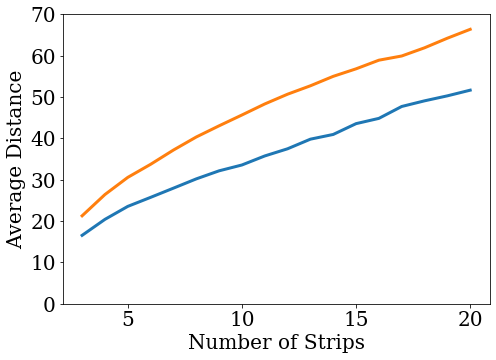

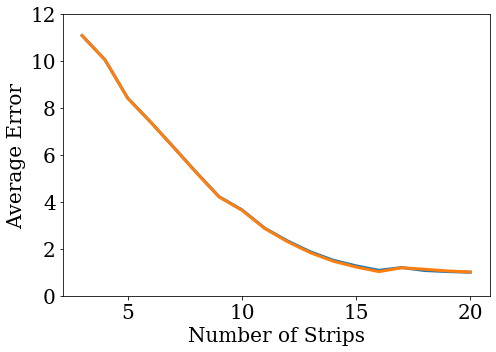

In [16]:
f1 = plt.figure(figsize=(7,5))
plt.rc('font',family='serif')
plt.tick_params(labelsize=20)
plt.plot(Ns,fh_dists, label='FH', linewidth=3)
plt.plot(Ns,qs_dists, label='QS', linewidth=3)


# plt.legend(fontsize=20)
plt.xlabel('Number of Strips', fontsize=20)
plt.ylabel('Average Distance', fontsize=20)
plt.ylim([0,70])
# plt.plot(Ns,2*np.pi*mu*np.ones(len(Ns)))
f1.tight_layout();
# f1.savefig('GP_dist_compare_strips_samps.eps',bbox_inches='tight');


f2 = plt.figure(figsize=(7,5))
plt.rc('font',family='serif')
plt.tick_params(labelsize=20)
plt.plot(Ns,tot_fh_errs, label='FH', linewidth=3)
plt.plot(Ns,tot_qs_errs, label='QS', linewidth=3)


# plt.legend(fontsize=20)
plt.xlabel('Number of Strips', fontsize=20)
plt.ylabel('Average Error', fontsize=20)
plt.ylim([0,12])
f2.tight_layout();
# f2.savefig('GP_err_compare_strips_samps.eps',bbox_inches='tight');

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


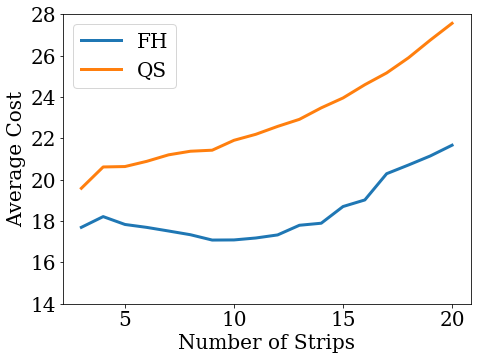

In [17]:
f2 = plt.figure(figsize=(7,5))
plt.rc('font',family='serif')
plt.tick_params(labelsize=20)
plt.plot(Ns,tot_fh_errs + lam*fh_dists, label='FH', linewidth=3)
plt.plot(Ns,tot_qs_errs + lam*qs_dists, label='QS', linewidth=3)


plt.legend(fontsize=20)
plt.xlabel('Number of Strips', fontsize=20)
plt.ylabel('Average Cost', fontsize=20)
plt.ylim([14,28])


f2.tight_layout();

# f2.savefig('GP_sim_compare_strips_samps.eps',bbox_inches='tight');